In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
customers = pd.read_csv("Customers.csv", encoding='latin1',sep=';')
products = pd.read_csv("Products.csv", encoding='latin1', on_bad_lines = 'skip',sep=';')
orders = pd.read_csv("Orders.csv", encoding='latin1',sep=';')
locations = pd.read_csv("Location.csv", encoding='latin1',sep=';')


In [8]:
print("Orders Columns:")
print(orders.columns.tolist())

print("\nCustomers Columns:")
print(customers.columns.tolist())

Orders Columns:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Segment', 'Postal Code', 'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit']

Customers Columns:
['Customer ID', 'Customer Name']


In [9]:
# Rename for consistency and convenience
orders.rename(columns={
    'Order ID': 'order_id',
    'Order Date': 'order_date',
    'Ship Date': 'ship_date',
    'Customer ID': 'customer_id',
    'Product ID': 'product_id',
    'Sales': 'total_price',
}, inplace=True)

customers.rename(columns={
    'Customer ID': 'customer_id',
    'Customer Name': 'customer_name'
}, inplace=True)


In [10]:
orders['order_date'] = pd.to_datetime(orders['order_date'], errors='coerce')
orders['ship_date'] = pd.to_datetime(orders['ship_date'], errors='coerce')


# Monthly Trends **

In [13]:
monthly_sales = orders.groupby(orders['order_date'].dt.to_period('M'))['total_price'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()

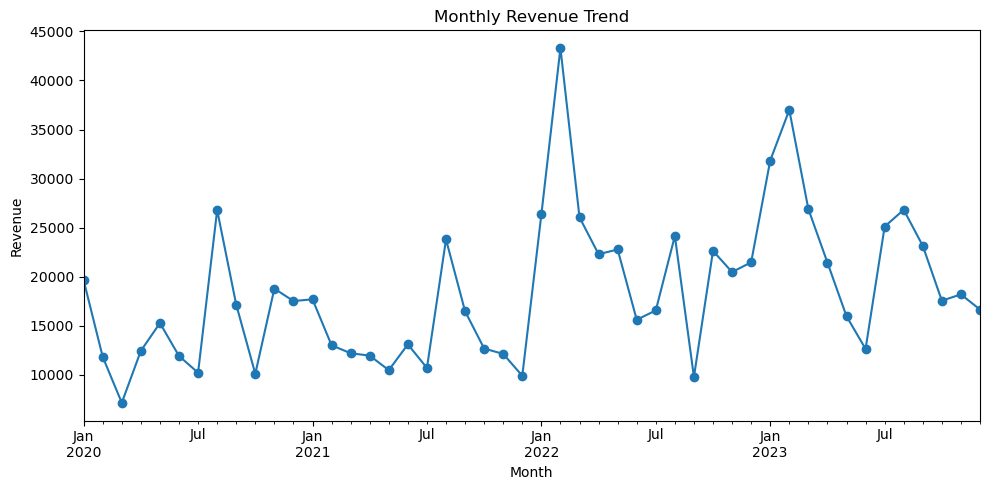

In [15]:
monthly_sales.plot(kind = 'line', marker= 'o', figsize=(10,5), title = 'Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

In [17]:
orders.columns = [
    'row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
    'customer_id', 'segment', 'postal_code', 'product_id',
    'total_price', 'quantity', 'discount', 'profit'
]


In [20]:
print(orders.columns.tolist())

['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id', 'segment', 'postal_code', 'product_id', 'total_price', 'quantity', 'discount', 'profit']


In [23]:
products.columns = ['product_id', 'category','sub_category', 'product_name']

In [24]:
print(products.columns.tolist())

['product_id', 'category', 'sub_category', 'product_name']


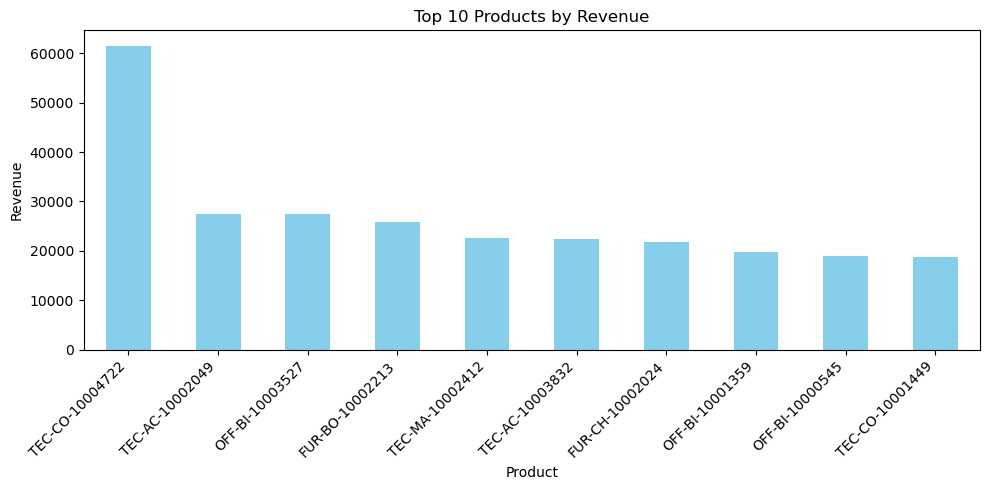

In [31]:
merged = orders.merge(products, on = 'product_id', how = 'left')
top_products = merged.groupby('product_id')['total_price'].sum().sort_values(ascending=False).head(10)

top_products.plot(kind = 'bar', color='skyblue', figsize=(10,5), title='Top 10 Products by Revenue')
plt.xlabel('Product')
plt.ylabel('Revenue')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

# Customer Insights #

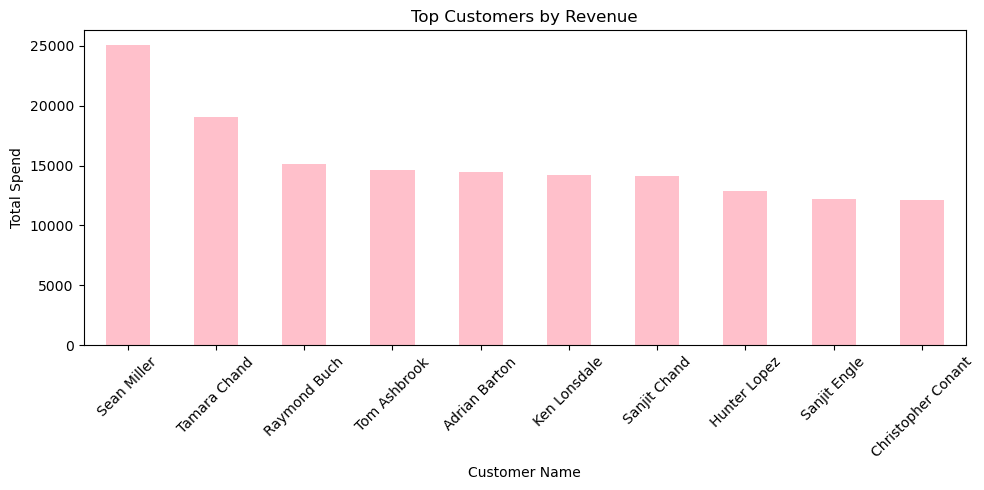

In [40]:
customers_merged = orders.merge(customers, on = 'customer_id', how = 'left')
top_customers = customers_merged.groupby('customer_name')['total_price'].sum().sort_values(ascending=False).head(10)

top_customers.plot(kind = 'bar',
                  color='pink',
                  figsize = (10,5),
                  title = 'Top Customers by Revenue')
plt.xlabel('Customer Name')
plt.ylabel('Total Spend')
plt.xticks(rotation= 45)
plt.tight_layout()
plt.show()

## Region wise and Segment wise Revenue

### Revenue by Segment

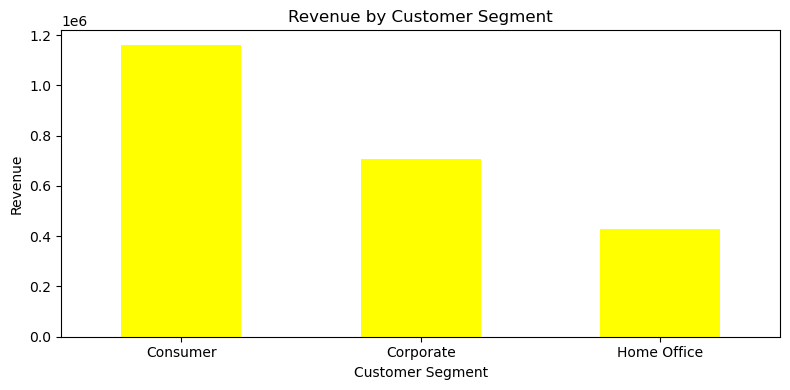

In [43]:
segment_sales = orders.groupby('segment')['total_price'].sum().sort_values(ascending = False)

segment_sales.plot(kind = 'bar',
                  color = 'yellow',
                  figsize = (8,4),
                  title = 'Revenue by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Revenue')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Revenue by Ship mode

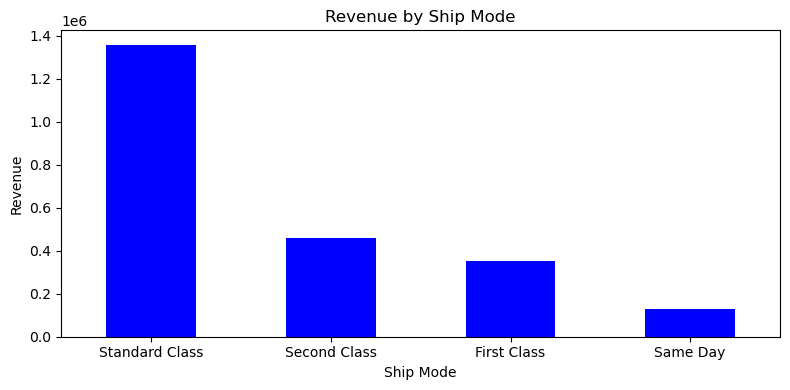

In [44]:
shipmode_sales = orders.groupby('ship_mode')['total_price'].sum().sort_values(ascending = False)

shipmode_sales.plot(kind='bar',
                    color= 'blue',
                    figsize=(8,4),
                    title = 'Revenue by Ship Mode')
plt.xlabel('Ship Mode')
plt.ylabel('Revenue')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### RFM(Recency, Frequency, Monetary) Analysis

In [48]:
import datetime

latest_date = orders['order_date'].max()

rfm = orders.groupby('customer_id').agg({
    'order_date': lambda x :(latest_date - x.max()).days,
    'order_id': 'nunique',
    'total_price':'sum'}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
print(rfm.head())

  customer_id  recency  frequency  monetary
0    AA-10315    648.0          5  5563.560
1    AA-10375     29.0          9  1056.390
2    AA-10480   1345.0          4  1790.512
3    AA-10645    214.0          6  5086.935
4    AB-10015    426.0          3   886.156


### RFM visualization

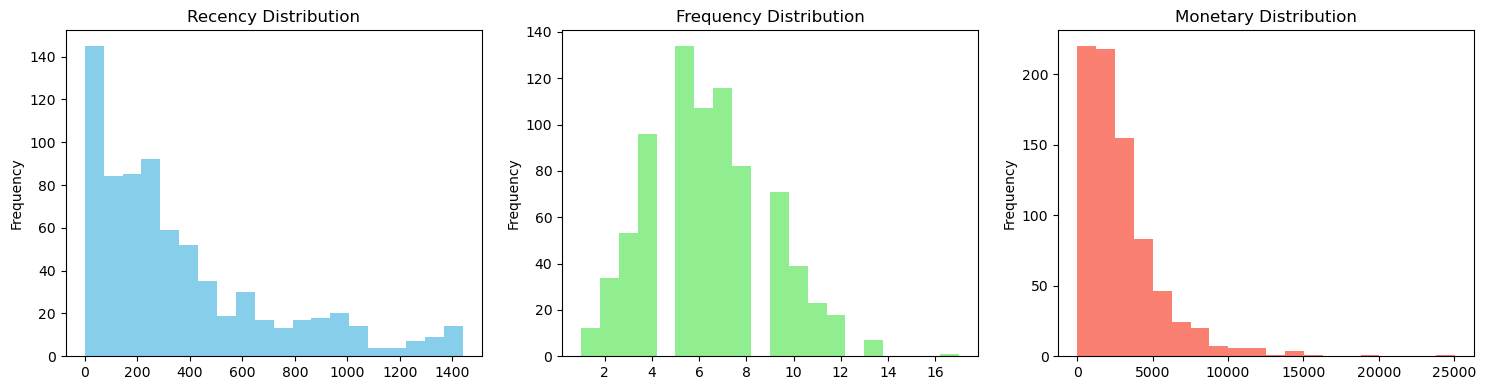

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

rfm['recency'].plot(kind='hist', bins=20, ax=axs[0], color='skyblue', title='Recency Distribution')
rfm['frequency'].plot(kind='hist', bins=20, ax=axs[1], color='lightgreen', title='Frequency Distribution')
rfm['monetary'].plot(kind='hist', bins=20, ax=axs[2], color='salmon', title='Monetary Distribution')

plt.tight_layout()
plt.show()


### Scoring and Segmentation

In [69]:
# R: lower is better (more recent), so reverse the scale
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

# F: higher is better
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# M: use fixed bins to reduce skew
rfm['m_score'] = pd.cut(
    rfm['monetary'],
    bins=[-1, 200, 500, 1000, 2000, rfm['monetary'].max()],
    labels=[1, 2, 3, 4, 5]
)


In [82]:
rfm['rfm_score'] = rfm['r_score'].astype(int) + rfm['f_score'].astype(int) + rfm['m_score'].astype(int)


In [78]:
print(rfm[['r_score', 'f_score', 'm_score']].isnull().sum())


r_score    55
f_score     0
m_score     0
dtype: int64


In [80]:
rfm['r_score'] = rfm['r_score'].fillna(1)



In [81]:
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']


In [83]:
def assign_segment(score):
    if score >= 13:
        return 'Champions'
    elif score >= 11:
        return 'Loyal'
    elif score >= 9:
        return 'Potential Loyalist'
    elif score >= 6:
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm['customer_segment'] = rfm['rfm_score'].apply(assign_segment)


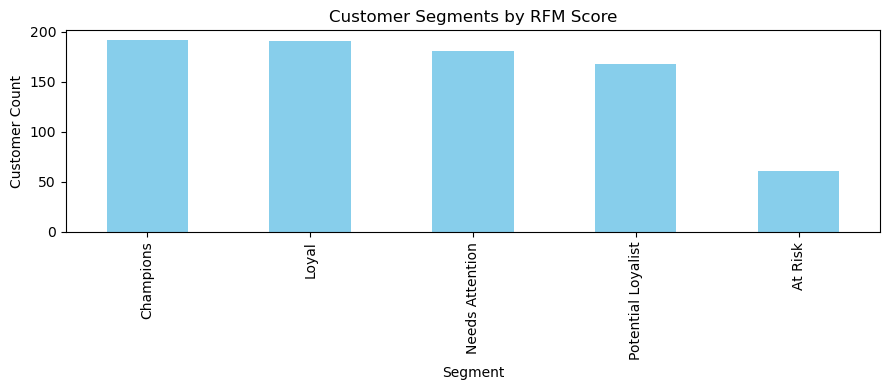

In [84]:
import matplotlib.pyplot as plt

rfm['customer_segment'].value_counts().plot(
    kind='bar',
    color='skyblue',
    figsize=(9, 4),
    title='Customer Segments by RFM Score'
)
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()


In [85]:
rfm.to_csv("final_rfm_segments.csv", index=False)
